In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Loading Data

In [2]:
data = pd.read_csv("../data/employee_retention.csv", parse_dates=["join_date", "quit_date"])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [4]:
data["employee_id"] = data["employee_id"].astype("O")
data["company_id"] = data["company_id"].astype("O")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  object        
 1   company_id   24702 non-null  object        
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 1.3+ MB


In [6]:
for col in data.columns:
    print("Column:", col)
    print(data[col].describe(datetime_is_numeric=True))
    print()

Column: employee_id
count     24702.0
unique    24702.0
top       32767.0
freq          1.0
Name: employee_id, dtype: float64

Column: company_id
count     24702
unique       12
top           1
freq       8486
Name: company_id, dtype: int64

Column: dept
count                24702
unique                   6
top       customer_service
freq                  9180
Name: dept, dtype: object

Column: seniority
count    24702.000000
mean        14.127803
std          8.089520
min          1.000000
25%          7.000000
50%         14.000000
75%         21.000000
max         99.000000
Name: seniority, dtype: float64

Column: salary
count     24702.000000
mean     138183.345478
std       76058.184573
min       17000.000000
25%       79000.000000
50%      123000.000000
75%      187000.000000
max      408000.000000
Name: salary, dtype: float64

Column: join_date
count                            24702
mean     2013-06-29 09:39:37.556460800
min                2011-01-24 00:00:00
25%                

## Calculating and visualizing employee headcount

We'll create a table containing a cartesian product of the dates and company ids and merge the "join" and "quit" data with it to calculate the headcount for each company.

In [7]:
period = pd.date_range("2011/01/24", "2015/12/13")
company_ids = data["company_id"].unique()
prod_df = pd.DataFrame(list(itertools.product(period, company_ids)), columns=['day', 'company_id'])
prod_df = prod_df.sort_values(by=["company_id", "day"])
prod_df

,day,company_id
4,2011-01-24,1
16,2011-01-25,1
28,2011-01-26,1
40,2011-01-27,1
52,2011-01-28,1
...,...,...
21371,2015-12-09,12
21383,2015-12-10,12
21395,2015-12-11,12
21407,2015-12-12,12


In [8]:
joined = data.groupby(["company_id", "join_date"]).count()["employee_id"].reset_index()
joined["total_joined"] = joined.groupby("company_id").expanding().sum()["employee_id"].reset_index()["employee_id"]
joined

,company_id,join_date,employee_id,total_joined
0,1,2011-01-24,25,25.0
1,1,2011-01-25,2,27.0
2,1,2011-01-26,2,29.0
3,1,2011-01-31,30,59.0
4,1,2011-02-01,7,66.0
...,...,...,...,...
5125,12,2014-05-19,2,20.0
5126,12,2014-10-13,1,21.0
5127,12,2015-03-23,1,22.0
5128,12,2015-07-06,1,23.0


In [9]:
quit = data.groupby(["company_id", "quit_date"]).count()["employee_id"].reset_index()
quit["total_quit"] = quit.groupby("company_id").expanding().sum()["employee_id"].reset_index()["employee_id"]
quit

,company_id,quit_date,employee_id,total_quit
0,1,2011-10-21,1,1.0
1,1,2011-11-11,1,2.0
2,1,2011-11-22,1,3.0
3,1,2011-11-25,1,4.0
4,1,2011-12-09,1,5.0
...,...,...,...,...
2719,12,2013-10-18,1,7.0
2720,12,2013-10-25,1,8.0
2721,12,2014-02-07,1,9.0
2722,12,2014-09-19,1,10.0


In [10]:
merged_joined = pd.merge(prod_df, joined, how="left", left_on=["company_id", "day"], right_on=["company_id", "join_date"])
merged_all = pd.merge(merged_joined, quit, how="left", left_on=["company_id", "day"], right_on=["company_id", "quit_date"])
merged_all = merged_all[["day", "company_id", "total_joined", "total_quit"]]

merged_all[["total_joined", "total_quit"]] = merged_all.groupby("company_id").ffill()[["total_joined", "total_quit"]]
merged_all[["total_joined", "total_quit"]] = merged_all[["total_joined", "total_quit"]].fillna(0)

merged_all["employee_headcount"] = merged_all["total_joined"] - merged_all["total_quit"]

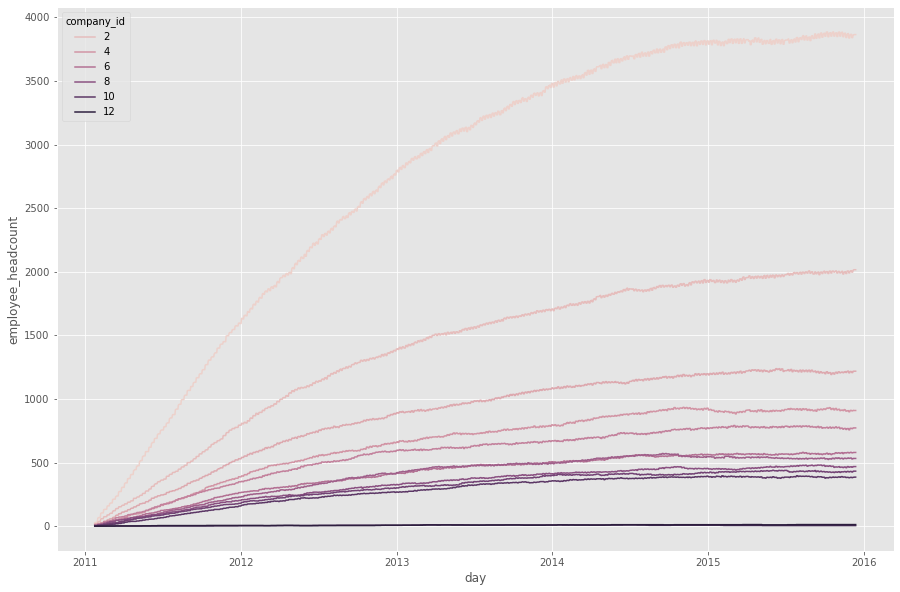

In [11]:
plt.subplots(figsize=(15,10))
sns.lineplot(x="day", y="employee_headcount", hue="company_id", data=merged_all);

Headcounts for all companies rise steadily. Companies 1 and 2 seem to be growing a lot faster than the rest of the pack.

In [12]:
cols = ["day", "company_id", "employee_headcount"]
output = merged_all.sort_values(by="day")[cols].reset_index(drop=True)
output

,day,company_id,employee_headcount
0,2011-01-24,1,25.0
1,2011-01-24,11,0.0
2,2011-01-24,10,0.0
3,2011-01-24,9,3.0
4,2011-01-24,8,6.0
...,...,...,...
21415,2015-12-13,3,1218.0
21416,2015-12-13,2,2016.0
21417,2015-12-13,1,3865.0
21418,2015-12-13,11,4.0


## Analyzing the main factors that drive employee churn

In [13]:
data["has_quit"] = data["quit_date"].notnull()
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,True
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,False
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,True


In [14]:
data["tenure"] = (data["quit_date"] - data["join_date"]).dt.days
data.head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit,tenure
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,False,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040.0
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,True,578.0
6,88600,4,customer_service,21,107000.0,2013-10-21,NaT,False,NaN
7,716309,2,customer_service,4,30000.0,2014-03-05,NaT,False,NaN
8,172999,9,engineer,7,160000.0,2012-12-10,2015-10-23,True,1047.0
9,504159,1,sales,7,104000.0,2012-06-12,NaT,False,NaN


In [15]:
max_date = data["join_date"].max()
nan_tenure_idx = data[data["tenure"].isnull()].index
data.loc[nan_tenure_idx, "tenure"] = (max_date - data["join_date"]).dt.days
data.head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit,tenure
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,False,423.0
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040.0
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,True,578.0
6,88600,4,customer_service,21,107000.0,2013-10-21,NaT,False,780.0
7,716309,2,customer_service,4,30000.0,2014-03-05,NaT,False,645.0
8,172999,9,engineer,7,160000.0,2012-12-10,2015-10-23,True,1047.0
9,504159,1,sales,7,104000.0,2012-06-12,NaT,False,1276.0


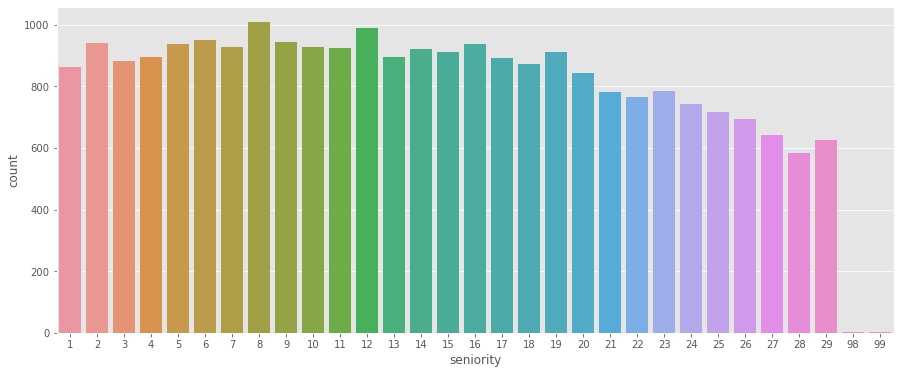

In [16]:
plt.subplots(figsize=(15,6))
sns.countplot(x="seniority", data=data);

In [17]:
data[data["seniority"] > 90]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit,tenure
24700,97289,10,engineer,98,266000.0,2011-12-13,2015-01-09,True,1123.0
24701,604052,1,marketing,99,185000.0,2011-07-26,2013-12-06,True,864.0


There are 2 people whose seniority level is 98 and 99 years. This doesn't look right, so we'll just remove those entries.

In [18]:
data = data[data["seniority"] < 90]

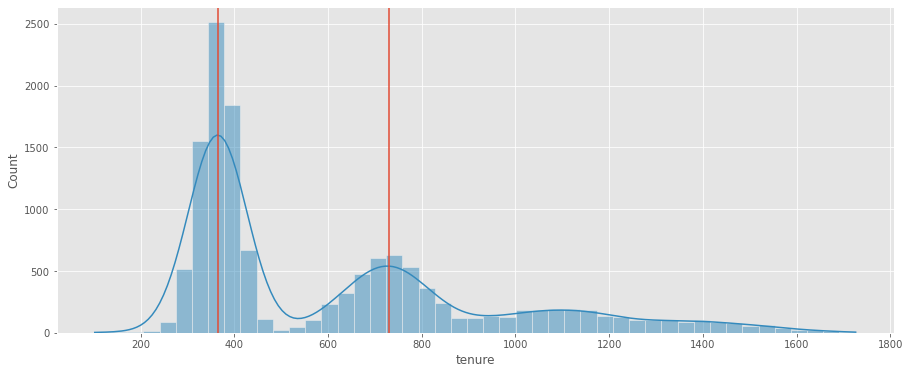

In [19]:
plt.subplots(figsize=(15,6))
sns.histplot(x="tenure", data=data[data["has_quit"] == True], kde=True)
plt.axvline(365, 0)
plt.axvline(730, 0);

We clearly see that most people usually quit after working for about 1 or 2 years. 

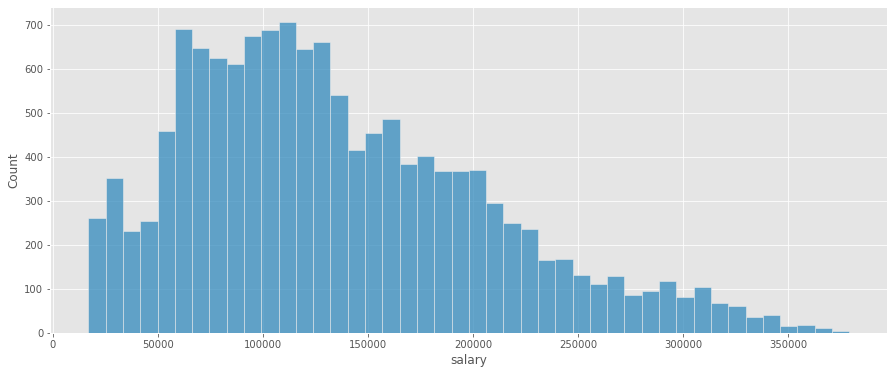

In [20]:
plt.subplots(figsize=(15,6))
sns.histplot(x="salary", data=data[data["has_quit"] == True]);

The salary histogram is skewed to the right. 
People feel more secure with higher salaries, so fewer people tend to quit.
Also, people with low salaries quit less, probably because they are not as marketable, so it's hard for them to change jobs.

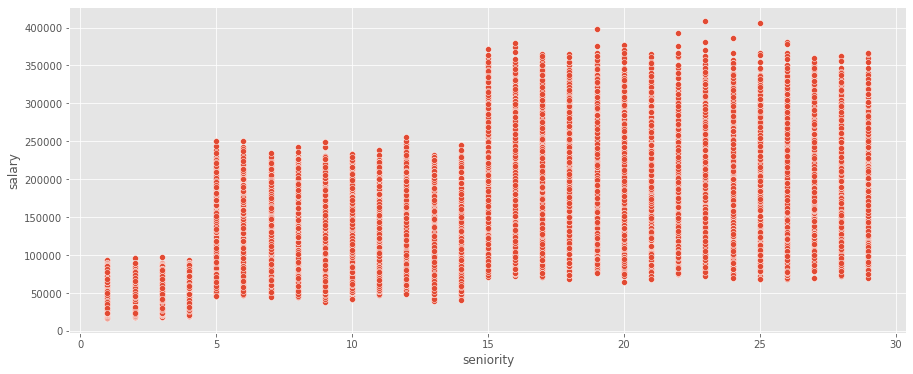

In [21]:
plt.subplots(figsize=(15,6))
sns.scatterplot(y="salary", x="seniority", data=data);

We see 3 distinct categories of seniority, let's make a new feature reflecting that.

In [22]:
bins = [-1, 4, 14, 100]
category = ['junior', 'mid', 'senior']
data["seniority_level"] = pd.cut(data['seniority'], bins, labels=category).astype('O')
data.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit,tenure,seniority_level
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585.0,senior
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340.0,senior
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,False,423.0,mid
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389.0,senior
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040.0,senior


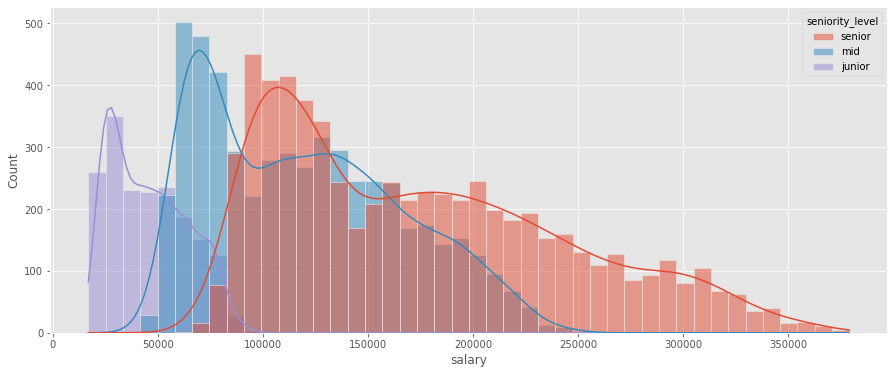

In [23]:
plt.subplots(figsize=(15,6))
sns.histplot(x="salary", hue="seniority_level", data=data[data["has_quit"] == True], kde=True);

Again, we see the same trend: people with higher salaries tend to quit less across all seniority levels.

Juniors and seniors tend to quit less than their mid-level counterparts.

In [24]:
data["quit_day"] = data["quit_date"].dt.day
data["quit_month"] = data["quit_date"].dt.month
data["quit_dayofweek"] = data["quit_date"].dt.dayofweek
data["quit_weekofyear"] = data["quit_date"].dt.week
data.head()

<ipython-input-24-a37f818f316b>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data["quit_weekofyear"] = data["quit_date"].dt.week


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit,tenure,seniority_level,quit_day,quit_month,quit_dayofweek,quit_weekofyear
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585.0,senior,30.0,10.0,4.0,44.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340.0,senior,4.0,4.0,4.0,14.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,False,423.0,mid,NaN,NaN,NaN,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389.0,senior,7.0,6.0,4.0,23.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040.0,senior,22.0,8.0,4.0,34.0


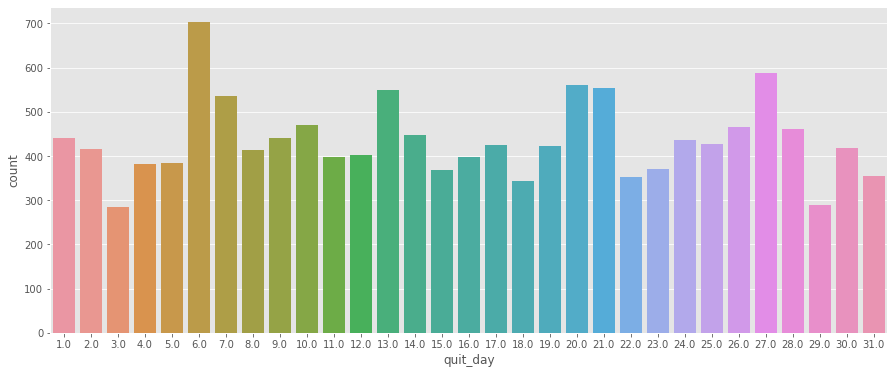

In [25]:
plt.subplots(figsize=(15,6))
sns.countplot(x="quit_day", data=data);

There's no clear relationship between the number of quitters and the day when they quit.

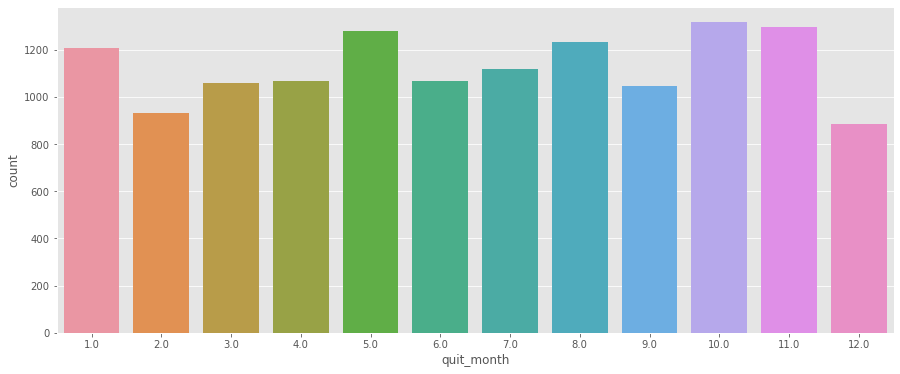

In [26]:
plt.subplots(figsize=(15,6))
sns.countplot(x="quit_month", data=data);

People tend to quit their jobs less in December. Companies are not as active to hire new people during the holiday season. Also, employees probably stay for the year-end bonus, then leave in January.

May, October and November are the months when people tend to quit more.

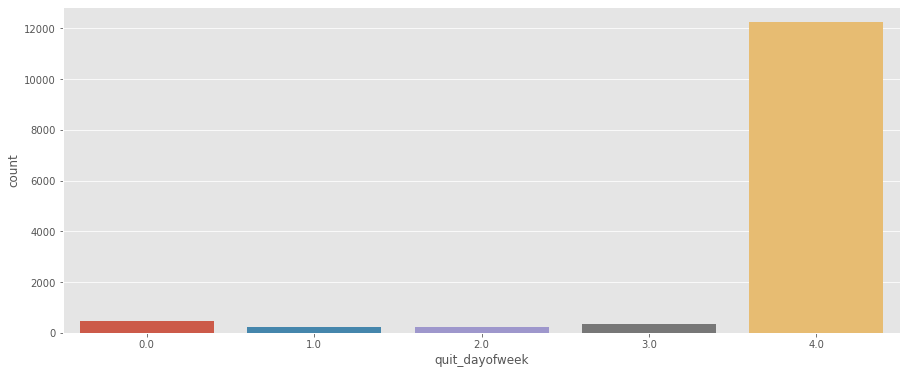

In [27]:
plt.subplots(figsize=(15,6))
sns.countplot(x="quit_dayofweek", data=data);

The majority of people quit on Friday. Most people probably give their two-week notice on Monday, which makes their last two weeks take fewer calendar days.

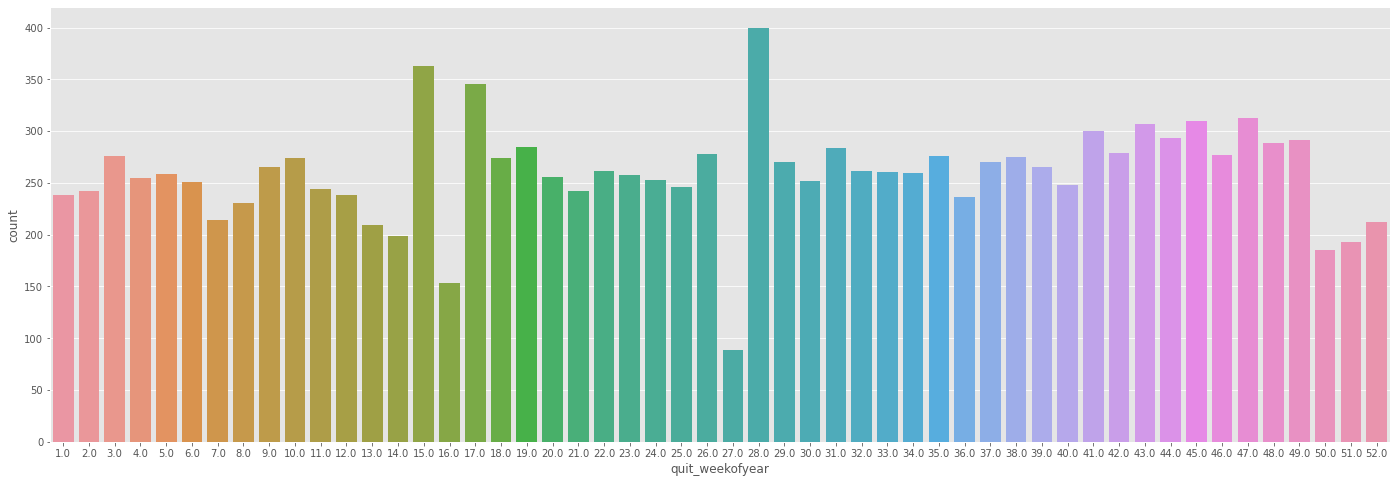

In [28]:
plt.subplots(figsize=(24,8))
sns.countplot(x="quit_weekofyear", data=data);

Fewer people quit jobs in the last three weeks of the year, because of it's the holiday season. There are a few down weeks in the spring (end of April) and summer (week of 4th of July), but there's no clear relationship otherwise.

## Predicting 1- and 2-year quitters and understanding why they quit

First, we predict how likely people are to quit their jobs within the first 1.5 year (~ 500 days).

In [29]:
day_range = 500
cutoff_date = pd.to_datetime("2015/12/13") - np.timedelta64(day_range,'D') 
df_early_quit = data[data["join_date"] < cutoff_date].copy()
df_early_quit.loc[:, "early_quit"] = df_early_quit["quit_date"].notnull() & (df_early_quit["quit_date"] < df_early_quit["join_date"] + np.timedelta64(day_range,'D'))
df_early_quit.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit,tenure,seniority_level,quit_day,quit_month,quit_dayofweek,quit_weekofyear,early_quit
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585.0,senior,30.0,10.0,4.0,44.0,False
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340.0,senior,4.0,4.0,4.0,14.0,True
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389.0,senior,7.0,6.0,4.0,23.0,True
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040.0,senior,22.0,8.0,4.0,34.0,False
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,True,578.0,mid,30.0,8.0,4.0,35.0,False


It's hard for companeis to control the date factors, so we're not going to include them in our predictive model.

In [30]:
X = pd.get_dummies(df_early_quit[["company_id", "dept", "seniority", "salary"]])
y = df_early_quit["early_quit"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
clf = RandomForestClassifier(n_estimators=200)

In [32]:
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

In [33]:
accuracy_score(y_test, predicted)

0.5579182988248461

In [34]:
vals = list(zip(X_train.columns, clf.feature_importances_))
pd.DataFrame(vals, columns=["Column", "Importance"]).sort_values(by="Importance", ascending=False)

,Column,Importance
1,salary,0.649237
0,seniority,0.281290
2,company_id_1,0.005504
4,company_id_3,0.005384
6,company_id_5,0.005094
5,company_id_4,0.004820
7,company_id_6,0.004611
10,company_id_9,0.004561
3,company_id_2,0.004466
8,company_id_7,0.004365


The two main factors are **salary** and **seniority**, which have a combined importance of ~ 0.92.

Now we predict churn within the first 2.5 years (~ 900 days).

In [35]:
day_range = 900
cutoff_date = pd.to_datetime("2015/12/13") - np.timedelta64(day_range,'D') 
df_quit = data[data["join_date"] < cutoff_date].copy()
df_quit.loc[:, "quit"] = df_quit["quit_date"].notnull() & (df_quit["quit_date"] < df_quit["join_date"] + np.timedelta64(day_range,'D'))
# df_quit = df_quit[~(df_quit["quit_date"].notnull() & (df_quit["tenure"] < 500))]
df_quit.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,has_quit,tenure,seniority_level,quit_day,quit_month,quit_dayofweek,quit_weekofyear,quit
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340.0,senior,4.0,4.0,4.0,14.0,True
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389.0,senior,7.0,6.0,4.0,23.0,True
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040.0,senior,22.0,8.0,4.0,34.0,False
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,True,578.0,mid,30.0,8.0,4.0,35.0,True
8,172999,9,engineer,7,160000.0,2012-12-10,2015-10-23,True,1047.0,mid,23.0,10.0,4.0,43.0,False


In [36]:
X = pd.get_dummies(df_quit[["company_id", "dept", "seniority", "salary"]])
y = df_quit["quit"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
clf = RandomForestClassifier(n_estimators=200)

In [38]:
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

In [39]:
accuracy_score(y_test, predicted)

0.5706214689265536

In [40]:
vals = list(zip(X_train.columns, clf.feature_importances_))
pd.DataFrame(vals, columns=["Column", "Importance"]).sort_values(by="Importance", ascending=False)

,Column,Importance
1,salary,0.616580
0,seniority,0.288277
2,company_id_1,0.008199
4,company_id_3,0.007354
3,company_id_2,0.007133
5,company_id_4,0.006683
6,company_id_5,0.006588
7,company_id_6,0.006396
9,company_id_8,0.006135
8,company_id_7,0.006079


Again, **salary** and **seniority** are the two main factors that affect employee churn. They have a combined importance of ~ 0.9.

## Conclusion

If companies want to improve employee retention, they need to pay attention to seniority of their employees and how much they pay them. The higher the salary, the less likely employees are to leave. Mid-level employees are more likely to quit than juniors and seniors.

If I could add one variable to the data set that would help explain employee churn, it would be **employee satisfaction score**. Knowing how employees feel and getting that answer directly from them would greatly help us predict if they want to stay or leave. While this metric shows the general sentiment about the workplace and is good for building a predictive model, it alone doesn't explain why an employee might be satisfied or dissatisfied with the company. Furthermore, depending on how this score is calculated, it might correlate with other factors that we already have in our data set.